Chapter 17

# 正交回归，二元
Book_7《机器学习》 | 鸢尾花书：从加减乘除到机器学习

In [1]:
###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis

def _get_coord_info_new(self, renderer):
    mins, maxs, cs, deltas, tc, highs = self._get_coord_info_old(renderer)
    correction = deltas * [0.25,
                           0.25,
                           0.25]
    mins += correction
    maxs -= correction
    return mins, maxs, cs, deltas, tc, highs
if not hasattr(Axis, "_get_coord_info_old"):
    Axis._get_coord_info_old = Axis._get_coord_info  
Axis._get_coord_info = _get_coord_info_new
###patch end###

In [2]:
# bi-variate regression

# initializations and download results 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf
import statsmodels.api as sm

In [3]:
X_y_df = yf.download(['AAPL','MCD','^GSPC'], start='2020-01-01', end='2020-12-31')
X_y_df.to_pickle('X_y_df.pkl')
X_y_df = X_y_df['Adj Close'].pct_change()
X_y_df.dropna(inplace = True)

[*********************100%%**********************]  3 of 3 completed


In [4]:
X_y_df.rename(columns={"^GSPC": "SP500"},inplace = True)
X_df = X_y_df[['AAPL','MCD']]
y_df = X_y_df[['SP500']]

In [5]:
#%% USE ODR in scipy

from scipy.odr import *

# Define a function to fit data
def linear_func(b, x):
   # b0, b1, b2 = b
   # x1, x2 = x
   # return b2*x2 + b1*x1 + b0
   b0 = b[0]
   b_ = b[1:]
   return b_.T@x + b0 

In [6]:
# Create a model for fitting
linear_model = Model(linear_func)

# Create a RealData object using our initiated data
data = RealData(X_df.T, y_df.T)

# Set up ODR with the model and data
odr = ODR(data, linear_model, beta0=[0., 1., 1])

# Run the regression
out = odr.run()

# Use pprint method to display results
out.pprint()

Beta: [-0.00062853  0.40867739  0.44286504]
Beta Std Error: [0.00057591 0.02462087 0.02874299]
Beta Covariance: [[ 5.48851338e-03 -2.33352037e-02  1.11519483e-02]
 [-2.33352037e-02  1.00312421e+01 -7.11129805e+00]
 [ 1.11519483e-02 -7.11129805e+00  1.36713688e+01]]
Residual Variance: 6.042991618082393e-05
Inverse Condition #: 0.16886232517779134
Reason(s) for Halting:
  Sum of squares convergence


In [7]:
#%% TLS, matrix computation

SIMGA = X_y_df.cov()

Lambda, V = np.linalg.eig(SIMGA)

idx = Lambda.argsort()[::-1]   
Lambda = Lambda[idx]
V = V[:,idx]

lambda_min = np.min(Lambda)

b1_TLS_ = -V[0,2]/V[2,2]
b2_TLS_ = -V[1,2]/V[2,2]

print(b1_TLS_)
print(b2_TLS_)

0.40865405083831985
0.4428944423422973


In [8]:
b0_TLS_ = y_df.mean().values - [b1_TLS_, b2_TLS_]@X_df.mean().values
print(b0_TLS_)

b0_TLS = out.beta[0]
b1_TLS = out.beta[1]
b2_TLS = out.beta[2]

[-0.00062848]


In [9]:
#%% OLS Regression

# add a column of ones
X_df = sm.add_constant(X_df)

model = sm.OLS(y_df, X_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     605.4
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           3.79e-96
Time:                        14:05:17   Log-Likelihood:                 827.38
No. Observations:                 251   AIC:                            -1649.
Df Residuals:                     248   BIC:                            -1638.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -1.012      0.3

In [10]:
p = model.fit().params
print(p)

const   -0.000579
AAPL     0.398361
MCD      0.408765
dtype: float64


In [11]:
# generate x-values for your regression line (two is sufficient)
xx1,xx2 = np.meshgrid(np.linspace(-0.15,0.15,20), np.linspace(-0.15,0.15,20))

yy_OLS = p.AAPL*xx1 + p.MCD*xx2 + p.const
yy_TLS = b1_TLS*xx1 + b2_TLS*xx2 + b0_TLS

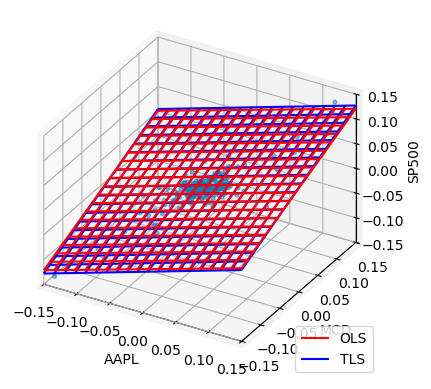

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_df["AAPL"], X_df["MCD"], y_df,
           s = 8, alpha = 0.5)

ax.plot_wireframe(xx1, xx2, yy_OLS, color = 'r', label = 'OLS')
ax.plot_wireframe(xx1, xx2, yy_TLS, color = 'b', label = 'TLS')

ax.set_xlim([-0.15,0.15])
ax.set_ylim([-0.15,0.15])
ax.set_zlim([-0.15,0.15])
ax.set_xlabel('AAPL')
ax.set_ylabel('MCD')
ax.set_zlabel('SP500')
ax.set_proj_type('ortho')
plt.legend(loc='lower right')

plt.savefig('比较回归结果.svg')